In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import seaborn
import torch
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI
from hdbscan import HDBSCAN
from umap.umap_ import UMAP
import openai
from datetime import datetime as dt

The following code imports both the files containing the transcripts of the videos alongside with their IDs, as well as the metadata of the videos

In [2]:
with open ('transcripts.pkl', 'rb') as file:
    transcripts = pickle.load(file=file)

with open ('./results/yt_data4.pkl', 'rb') as file:
    yt_data = pickle.load(file=file)

To look at the topic distribution over time, the relevant metadata (here the date of publication) needs to be seperated from the remaining metadata, then merged with the transcripts to create one coherent dataframe. This also ensures that the dates correspond correctly to the equivalent videos

In [3]:
vid_dates = pd.DataFrame(yt_data, columns=['vid_id', 'Publish_date'])

trans_dates = pd.merge(transcripts, vid_dates, left_on='Vid_Id', right_on='vid_id', how='inner')
trans_dates= trans_dates.drop(columns=['vid_id'])
trans_dates = trans_dates.reset_index(drop=True)

Next is creating a list of stopwords, so to filter out the irrelevant terms that would end up in the analysis

In [4]:
with open('./stopwords-de-master\stopwords-de.txt', 'r') as file:
    halt_stop = [line.rstrip() for line in file]

In [ ]:

vec_mod = CountVectorizer(stop_words=halt_stop)

Within the YouTube API, the dates are stored as strings, but the analysis requires them to be in a date format, thus, a conversation is necessary.
Additionally, a list is created from the column, necessary for the BERTopic package

In [5]:
date_list = trans_dates['Publish_date'].tolist()
for i in range(len(date_list)):
    date_list[i] = dt.strptime(date_list[i], "%Y-%m-%dT%H:%M:%SZ")

In [ ]:
text = trans_dates['Trans'].tolist()

This sets up the model with the necessary parameters. The values were chosen by trial and error using various values to ensure visibility and little to no overlap of topics

In [ ]:
umap_mod = UMAP(n_neighbors=10, n_components=10, min_dist=0.2, metric='cosine', random_state=1337)
mmr = MaximalMarginalRelevance(diversity=0.1)
key_mod = KeyBERTInspired()

In [ ]:
rep_model = {
    'Keybert': key_mod,
    'MMR': mmr
}

In [ ]:
model = BERTopic(
    vectorizer_model=vec_mod,
    representation_model=rep_model,
    umap_model=umap_mod,
    #hdbscan_model=hdb,
    language='german', calculate_probabilities=True,
    #nr_topics= 'auto',
    top_n_words=10,
    verbose=True
)
topics, prob = model.fit_transform(text)

2025-03-24 08:40:52,816 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/292 [00:00<?, ?it/s]

2025-03-24 08:53:25,081 - BERTopic - Embedding - Completed ✓
2025-03-24 08:53:25,099 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-24 08:55:08,649 - BERTopic - Dimensionality - Completed ✓
2025-03-24 08:55:08,649 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-24 08:55:15,600 - BERTopic - Cluster - Completed ✓
2025-03-24 08:55:15,673 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-24 08:57:01,730 - BERTopic - Representation - Completed ✓


This is a first rudimentary overlook over the topics, to get a first look at them before visualisation

In [11]:
model.get_topics()

{-1: [('für', np.float64(0.009003032918084434)),
  ('können', np.float64(0.006936966141445322)),
  ('sagen', np.float64(0.006489210276265717)),
  ('natürlich', np.float64(0.0064720631179234185)),
  ('über', np.float64(0.006444835979914481)),
  ('einfach', np.float64(0.005975627486092892)),
  ('eigentlich', np.float64(0.005852764852074417)),
  ('müssen', np.float64(0.005652494063006233)),
  ('musik', np.float64(0.005449793501591617)),
  ('heißt', np.float64(0.005097867835510813))],
 0: [('eis', np.float64(0.014827239501485122)),
  ('wasser', np.float64(0.010918399529107902)),
  ('musik', np.float64(0.010334829889762205)),
  ('grad', np.float64(0.009826483018324618)),
  ('temperaturen', np.float64(0.009003317301995222)),
  ('gletscher', np.float64(0.00891162883855137)),
  ('meter', np.float64(0.00863941750119261)),
  ('wetter', np.float64(0.008354607407909883)),
  ('sommer', np.float64(0.007861839842083442)),
  ('winter', np.float64(0.0077657039994680314))],
 1: [('wald', np.float64(0.02

The intertopic distance map is used to identify (thematic) clusters. In combination with the previous first look at topics, it will also be used to filter out irrelevant topics or ones filled with stopwords

While the heatmap offers a similar approach based on the similarity of topics, the overall results overlap with the intertopic distance maps

In [13]:
#topics_list = [1]
#top_range = topics_list + list(range(3,39))
model.visualize_topics()

In [18]:
topic_list = list(range(1,4)) + [6] + [8] + list(range(10,24)) + list(range(25,52)) + list(range(53,79))

In [45]:
model.visualize_topics(topics=topic_list)

In [17]:
model.visualize_heatmap(n_clusters=20)

This is to save the current progress into a pickle file, so to enable the analysis over multiple days

In [33]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file=file)

The approach over the next steps is to generate the necessary plots based on the clusters to first determine the overarching theme, then the distribution of the topics over time

In [29]:
model.visualize_barchart(topics=[1,21,57,2,34,46,73], n_words=10, height=300)

In [33]:
model.visualize_barchart(topics=[3, 76, 53, 39, 25, 31, 40, 47, 55], n_words=10, height=300, width=350)

In [46]:
model.visualize_barchart(topics=[6, 67, 72, 58, 68, 27, 17], n_words=10, height=300, width=350)

In [47]:
model.visualize_barchart(topics=[10,18,64,36,70,50,78], n_words=10, height=300, width=350)

In [53]:
model.visualize_barchart(topics=[11,75, 30, 65, 69], n_words=10, height=300, width=350)

In [48]:
model.visualize_barchart(topics=[8,49,54], n_words=10, height=300, width=350)

In [54]:
model.visualize_barchart(topics=[12,19,20,26,44], n_words=10, height=300, width=350)

In [55]:
model.visualize_barchart(topics=[13,33,14,15,35,71], n_words=10, height=300, width=350)

In [23]:
model.visualize_barchart(topics=[16, 32, 62, 28], n_words=10, height=300, width=300)

In [24]:
model.visualize_barchart(topics=[22, 43, 38, 63, 61], n_words=10, height=300, width=350)

In [25]:
model.visualize_barchart(topics=[29, 66, 60, 42], n_words=10, height=300, width=350)

In [30]:
model.visualize_barchart(topics=[37,74,41,56,45,48,59,77], n_words=10, height=300, width=400)

The following process strips the unnecessary time elements from the dates for the further analysis

In [12]:
date_raw  = []

for i in range(len(date_list)):
    date = date_list[i].strftime('%Y-%m-%d')
    date = date[:7]
    #date = dt.strptime(date, '%Y-%m-%d')
    date_raw.append(date)

date_counts = pd.DataFrame(date_raw).value_counts().sort_index()

<Axes: xlabel='0'>

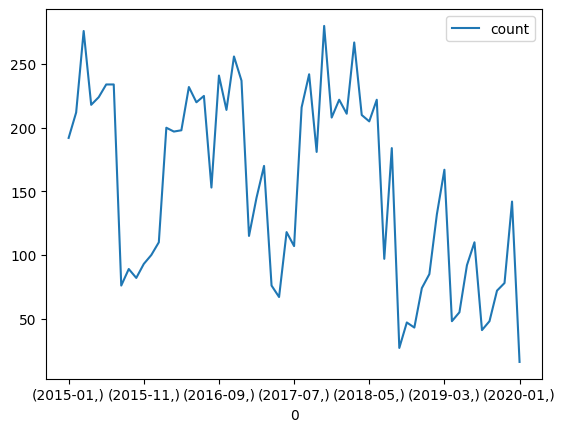

In [14]:
#date_counts = pd.DataFrame(date_list)
date_counts = pd.DataFrame(date_counts)

date_counts.plot()

In [12]:
topics_time = model.topics_over_time(text, date_list, nr_bins=50)

50it [03:23,  4.06s/it]


In [15]:
rev_tops = [1,2,3,6,8,10,11,12,13,29]

In [16]:
model.visualize_topics_over_time(topics_time, topics=rev_tops)


In [ ]:
rev_tops = [1,21,57]
model.visualize_topics_over_time(topics_time, topics=rev_tops)

In [13]:
rev_tops = [2,34,46,73]
model.visualize_topics_over_time(topics_time, topics=rev_tops)

In [19]:
rev_tops = [3,23,25,47,53,55,76]
model.visualize_topics_over_time(topics_time, topics=rev_tops)

In [20]:
rev_tops = [6,17,27,58,67,68,72]
model.visualize_topics_over_time(topics_time, topics=rev_tops)

In [21]:
rev_tops = [8,49,54]
model.visualize_topics_over_time(topics_time, topics=rev_tops)

In [22]:
rev_tops = [10,18,36,50,64,70,78]
model.visualize_topics_over_time(topics_time, topics=rev_tops)

In [23]:
rev_tops = [13,33,11,75]
model.visualize_topics_over_time(topics_time, topics=rev_tops)

In [24]:
rev_tops = [29,42,60,66]
model.visualize_topics_over_time(topics_time, topics=rev_tops)

For the last step, the channel categories are necessary, these are loaded in from the previous file with the code for scraping, then merged in a similar way to the dates

In [12]:
with open('cats_df.pkl', 'rb') as file:
    cats_df = pickle.load(file)

In [13]:
vid_cats = pd.DataFrame(yt_data, columns=['vid_id', 'Publish_date', 'Channel_ID'])

vid_cats = pd.merge(transcripts, vid_cats, left_on='Vid_Id', right_on='vid_id', how='inner')

vid_cats = pd.merge(vid_cats, cats_df, left_on='Channel_ID', right_on='Channel_ID', how='outer')

The categories are renamed and merged with the other existing categories, to ensure consistency and remove redundancy

To further ensure visibility, the representative topics are chosen within the graphic

In [14]:
for i in range(len(vid_cats)):
    if 'game' in vid_cats.loc[i,'TopicDetails']:
        vid_cats.loc[i, 'TopicDetails'] = 'Gaming'
    if 'music' in vid_cats.loc[i,'TopicDetails']:
        vid_cats.loc[i, 'TopicDetails'] = 'Music'

In [15]:
count_cats = pd.DataFrame(vid_cats['TopicDetails'].value_counts())

<Axes: xlabel='Channel Categories'>

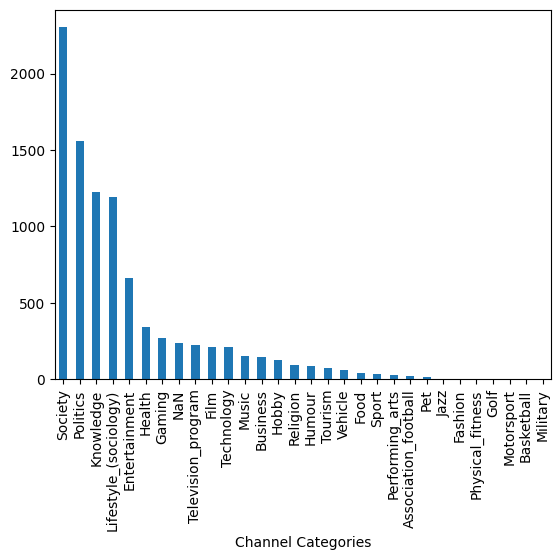

In [31]:

count_cats.plot.bar(xlabel='Channel Categories', legend=False)

In [19]:
model_cats = model.topics_per_class(text, classes=vid_cats.loc[:,'TopicDetails'])

30it [01:10,  2.33s/it]


In [21]:
rev_tops = [1,2,3,6,8,10,11,12,13,29]
model.visualize_topics_per_class(model_cats, topics=rev_tops)